# Imports and data loading

In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import sys

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from typing import Optional

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=True

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

set_seed(0)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [3]:
anndataset_10k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_5k = anndata.read(save_path + "pbmc_5k_protein_v3.h5ad")

In [4]:
adata_hvg = anndata.AnnData.concatenate(anndataset_10k, anndataset_5k)
seurat_v3_highly_variable_genes(adata_hvg)
global_high_var_genes = adata_hvg.var.index[adata_hvg.var["highly_variable"]]

anndataset_10k = anndataset_10k[:, adata_hvg.var.index]
anndataset_5k = anndataset_5k[:, adata_hvg.var.index]

(15792,)
(6855, 15792)
(15792,)
(3994, 15792)


In [5]:
dataset_10k = AnnDatasetFromAnnData(ad = anndataset_10k[:, global_high_var_genes])
protein_data_10k = CellMeasurement(name="protein_expression", data=anndataset_10k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_10k.uns["protein_names"])
dataset_10k.initialize_cell_measurement(protein_data_10k)

dataset_5k = AnnDatasetFromAnnData(ad = anndataset_5k[:, global_high_var_genes])
protein_data_5k = CellMeasurement(name="protein_expression", data=anndataset_5k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_5k.uns["protein_names"])
dataset_5k.initialize_cell_measurement(protein_data_5k)

[2020-09-16 22:18:22,218] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:22,220] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:22,276] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:22,323] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-16 22:18:22,449] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:22,452] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:22,488] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:22,516] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [6]:
# This modifies original datasets in place and intersects protein columns
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [dataset_10k, dataset_5k],
)

[2020-09-16 22:18:22,577] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-09-16 22:18:22,654] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:22,743] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:22,745] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:22,787] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:22,834] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:22,836] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:23,082] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:23,084] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:23,087] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


## Mask out 5k proteins

In [7]:
fiveK_proteins = dataset_5k.protein_expression.copy()
dataset_5k.protein_expression = np.zeros_like(dataset_5k.protein_expression)
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [dataset_10k, dataset_5k],
)

[2020-09-16 22:18:23,213] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-09-16 22:18:23,253] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:23,341] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:23,343] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:23,368] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-16 22:18:23,420] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:23,422] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:23,666] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-16 22:18:23,669] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-16 22:18:23,673] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


## Run model with masked out 5k

In [8]:
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

In [9]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_batch=dataset.n_batches,
    protein_batch_mask=batch_mask,
    encoder_batch=True
)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
    use_adversarial_loss=True,
    kappa=None,
)
trainer.train(lr=lr, n_epochs=500)

[2020-09-16 22:31:00,020] INFO - scvi.inference.trainer | Reducing LR on epoch 408.
[2020-09-16 22:32:07,215] INFO - scvi.inference.trainer | Reducing LR on epoch 449.
[2020-09-16 22:32:30,154] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-16 22:32:30,155] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


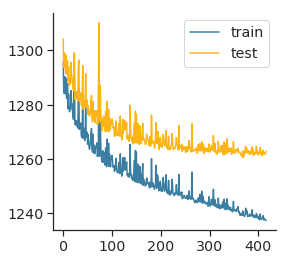

In [10]:
# plt.plot(trainer.history['elbo_validation_set'][50:], label="validation")
plt.plot(trainer.history['elbo_train_set'][50:], label="train")
plt.plot(trainer.history['elbo_test_set'][50:], label="test")
# plt.ylim(2500, 2600)
sns.despine()
plt.legend()

In [11]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# Number of Monte Carlo samples to average over
n_samples = 25

parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=0
)

In [12]:
protein_means = full_posterior.sequential().get_protein_mean(n_samples=25, transform_batch=0)

In [13]:
imputed_proteins = protein_means[dataset.batch_indices.ravel() == 1]

In [14]:
errors = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
corrs = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
pear_corrs = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])

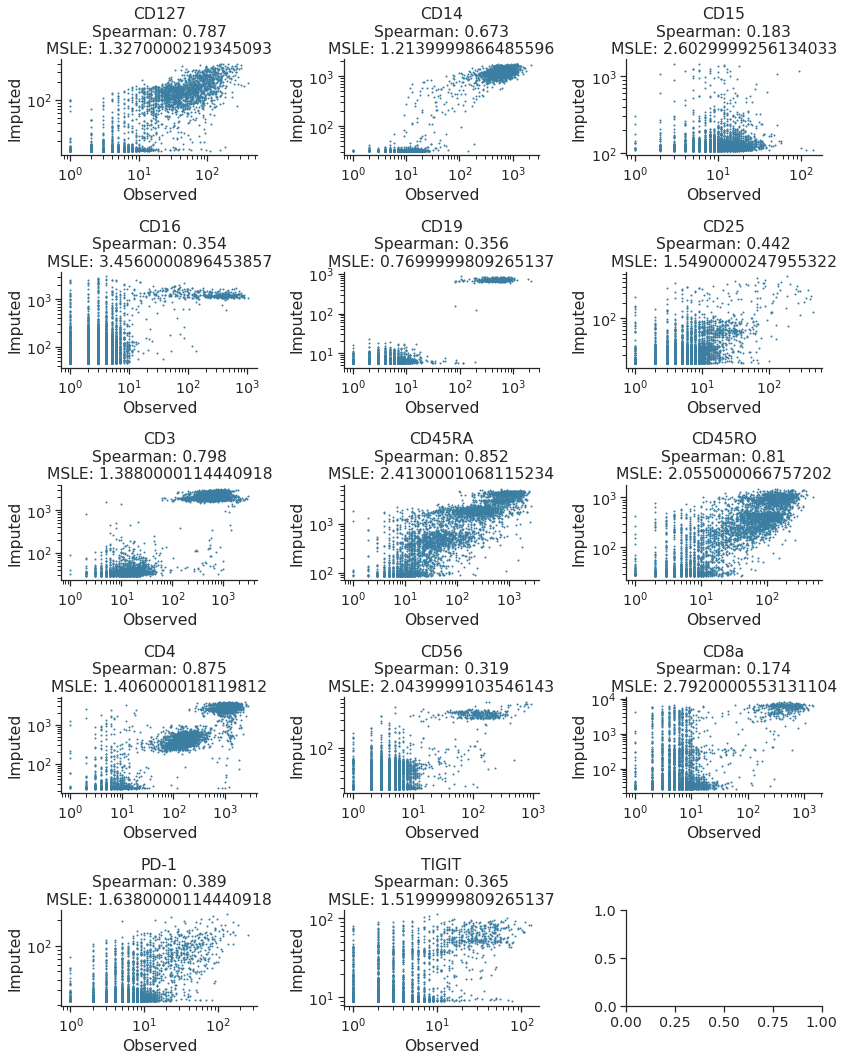

In [15]:
from scipy.stats import pearsonr, spearmanr

fig, axarr = plt.subplots(5, 3, figsize=(12, 15))
for i in range(len(dataset.protein_names)):
    axarr.flat[i].scatter(
        fiveK_proteins[:, i] + 1, imputed_proteins[:, i] + 1, s=1
    )
    axarr.flat[i].set_yscale('log')
    axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(imputed_proteins[:, i], fiveK_proteins[:, i])[
        0
    ]
    p_corr = pearsonr(np.log1p(imputed_proteins[:, i]), np.log1p(fiveK_proteins[:, i]))[
        0
    ]
    msle = np.round(np.sqrt(np.mean(
        np.square(np.log1p(imputed_proteins[:, i]) - np.log1p(fiveK_proteins[:, i]))
    )), 3)
    corrs.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = p_corr

    errors.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = msle
    axarr.flat[i].set_title(
        dataset.protein_names[i].split("_")[0]
        + "\nSpearman: {}\nMSLE: {}".format(np.round(s_corr, 3), msle)
    )
    axarr.flat[i].set_xlabel("Observed")
    axarr.flat[i].set_ylabel("Imputed")
plt.tight_layout()
sns.despine()
plt.tight_layout()

In [16]:
post_adata = anndata.AnnData(X=denoised_genes)
post_adata.var.index = dataset.gene_names
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=40)
sc.tl.umap(post_adata, min_dist=0.2)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.9)
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{} Protein".format(p)] = denoised_proteins[:, i]
    post_adata.obs["{} Protein mean".format(p)] = protein_means[:, i]
post_adata.obs["batch_indices"] = dataset.batch_indices
d_names = ["PBMC-10k", "PBMC-5k (held-out proteins)"]
post_adata.obs["batch_indices"] = [d_names[b[0]] for b in dataset.batch_indices]

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


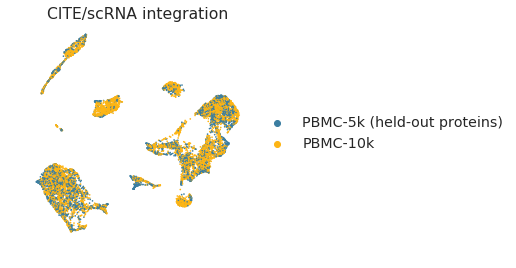

In [17]:
perm_inds = np.random.permutation(len(post_adata))
fig = sc.pl.umap(
    post_adata[perm_inds], 
    color=["batch_indices"],
    title="CITE/scRNA integration",
    return_fig=True,
    frameon=False
)
plt.savefig("figures/pbmc_cite_scrna.pdf", dpi=DPI, bbox_inches="tight")

### save data for Seurat

In [18]:
# batch_0_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.gene_names,
#     columns=anndataset_10k.obs.index,
#     dtype=np.float32,
# )
# batch_0_pro = pd.DataFrame(
#     dataset.protein_expression[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.protein_names,
#     columns=anndataset_10k.obs.index,
#     dtype=np.float32,
# )

# batch_1_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 1].T,
#     index=dataset.gene_names,
#     columns=anndataset_5k.obs.index,
#     dtype=np.float32,
# )

# save_path_csv = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/raw_data/"

# batch_0_rna.to_csv(save_path_csv + "pbmc10k_harmo_rna.csv.gz")
# batch_0_pro.to_csv(save_path_csv + "pbmc10k_harmo_pro.csv.gz")
# batch_1_rna.to_csv(save_path_csv + "pbmc5k_harmo_rna.csv.gz")

### Load seurat imputed

In [19]:
seurat_imputed = pd.read_csv(
    "/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/seurat_harmo_results/imputed_pbmc.csv", 
    index_col=0,
).transpose()

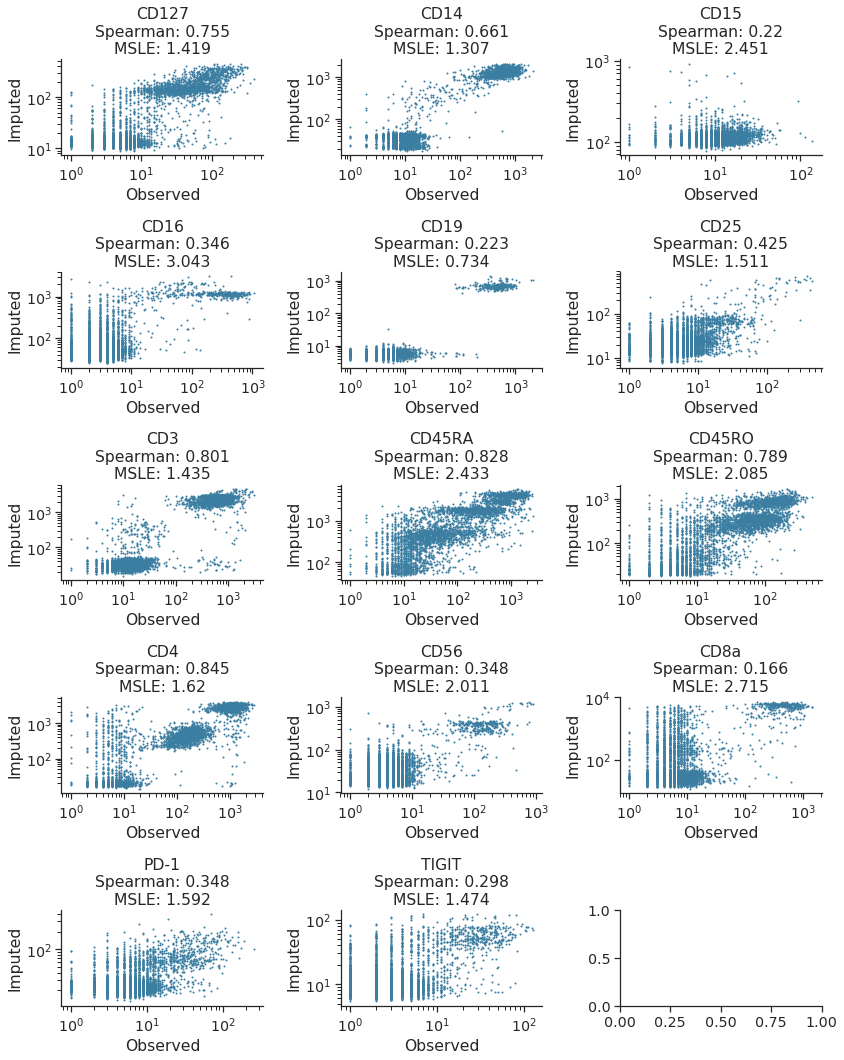

In [20]:
fig, axarr = plt.subplots(5,3, figsize=(12,15))
for i in range(len(dataset.protein_names)):
    axarr.flat[i].scatter(
        fiveK_proteins[:, i] + 1,
        seurat_imputed.iloc[:, i] + 1,
        s=1,
    )
    axarr.flat[i].set_yscale('log')
    axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(
        seurat_imputed.iloc[:, i], fiveK_proteins[:, i]
    )[0]
    p_corr = pearsonr(
        np.log1p(seurat_imputed.iloc[:, i]), np.log1p(fiveK_proteins[:, i])
    )[0]
    msle = np.round(np.sqrt(np.mean(np.square(
        np.log1p(fiveK_proteins[:, i]) - np.log1p(seurat_imputed.iloc[:, i])
    ))), 3)
    errors.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = msle
    corrs.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = p_corr

    axarr.flat[i].set_title(
        dataset.protein_names[i].split("_")[0]
        + "\nSpearman: {}\nMSLE: {}".format(np.round(s_corr, 3), msle)
    )
    axarr.flat[i].set_xlabel("Observed")
    axarr.flat[i].set_ylabel("Imputed")
plt.tight_layout()
sns.despine()
plt.tight_layout()

In [21]:
colors = ["#3B7EA1", "#859438", "#FDB515", "#D9661F", "#EE1F60", "#00A598"]
sns.set_palette(sns.color_palette(colors))

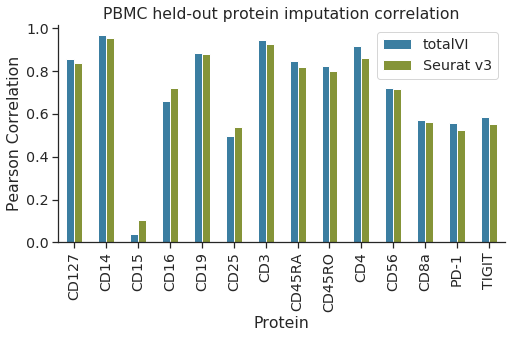

In [22]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(8, 4))
    pear_corrs.plot(kind="bar", ax=ax)
    ax.set_ylabel("Pearson Correlation")
    ax.set_xlabel("Protein")
    plt.legend(fancybox=True)
    ax.set_title("PBMC held-out protein imputation correlation")
    sns.despine()
#     fig.savefig("figures/pbmc_imputation_correlation_pearson.pdf", bbox_inches="tight")

## CTPnet

In [23]:
import ctpnet

gene_list = pd.read_csv("ctp_net_gene_list.csv")["x"].values


adata_5k = anndata.read(save_path + "pbmc_5k_protein_v3.h5ad")
sc.pp.normalize_per_cell(adata_5k, counts_per_cell_after=10000)
sc.pp.log1p(adata_5k)
data = adata_5k.to_df().transpose()
data_skeleton = pd.DataFrame(np.zeros((len(gene_list), data.shape[1])), index=gene_list)


# denoised = denoised_genes[dataset.batch_indices.ravel() == 1]
# denoised_df = pd.DataFrame(np.log((denoised * 10000) + 1), columns=dataset.gene_names)
# data = denoised_df.transpose()

inter = np.intersect1d(gene_list, data.index)

# inter = np.intersect1d(gene_list, adata_5k.var_names)
# print(len(inter))
data_skeleton.loc[inter] = data.loc[inter].values


ctpnet_prediction = ctpnet.predict.predict(data_skeleton, "cTPnet_weight_24", d=24)


python package loaded
convert input
init network
load network
imputation
convert format
python done


In [24]:
ctpnet_prediction = ctpnet_prediction.transpose()
ctpnet_prediction["CD8a"] = ctpnet_prediction["CD8"]
ctpnet_prediction = ctpnet_prediction.loc[:, pear_corrs.index]


/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/pandas-0.25.1-py3.7-linux-x86_64.egg/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [25]:
ctpnet_prediction.head()
# for missing proteins
ctpnet_prediction = ctpnet_prediction.fillna(0)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/scipy-1.3.1-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/scipy-1.3.1-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/scipy-1.3.1-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure

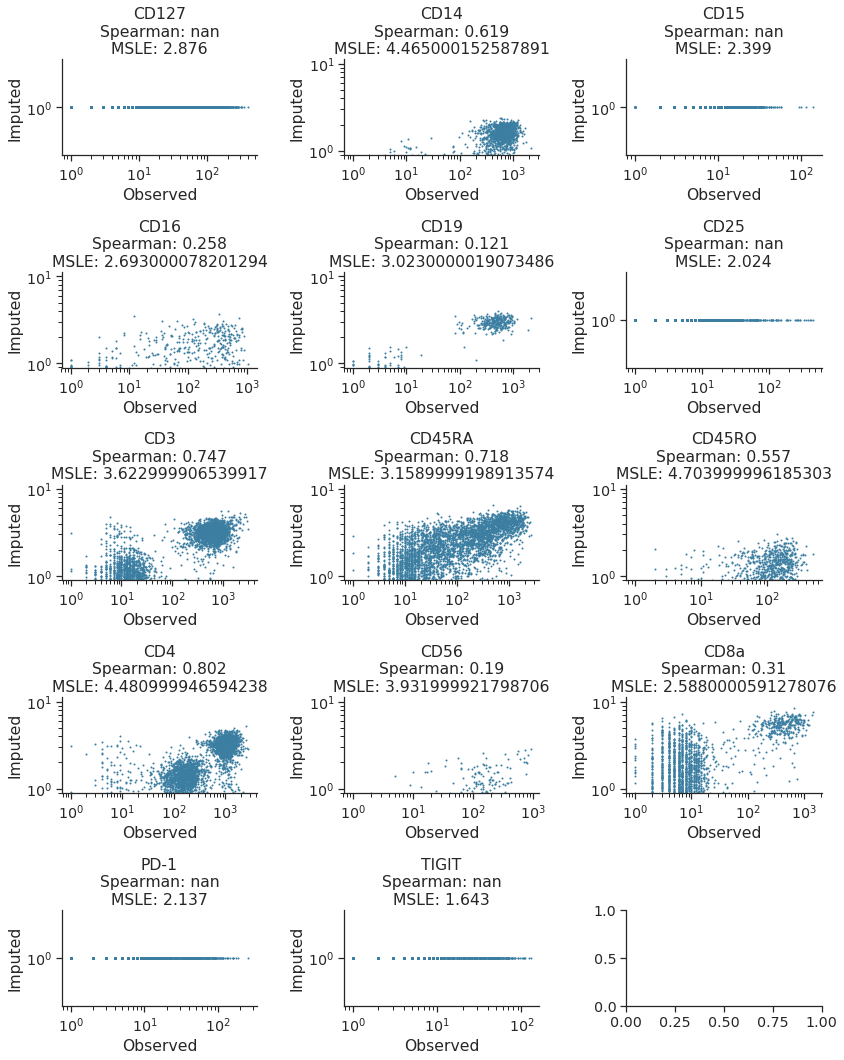

In [26]:
fig, axarr = plt.subplots(5,3, figsize=(12,15))
for i in range(len(dataset.protein_names)):
    axarr.flat[i].scatter(
        fiveK_proteins[:, i] + 1,
        ctpnet_prediction.iloc[:, i] + 1,
        s=1,
    )
    axarr.flat[i].set_yscale('log')
    axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(
        ctpnet_prediction.iloc[:, i], fiveK_proteins[:, i]
    )[0]
    try:
        p_corr = pearsonr(
            ctpnet_prediction.iloc[:, i], np.log1p(fiveK_proteins[:, i])
        )[0]
    except:
        p_corr = 0
    msle = np.round(np.sqrt(np.mean(np.square(
        np.log1p(fiveK_proteins[:, i]) - ctpnet_prediction.iloc[:, i]
    ))), 3)
    errors.loc[dataset.protein_names[i].split("_")[0], "cTPnet"] = msle
    corrs.loc[dataset.protein_names[i].split("_")[0], "cTPnet"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[0], "cTPnet"] = p_corr

    axarr.flat[i].set_title(
        dataset.protein_names[i].split("_")[0]
        + "\nSpearman: {}\nMSLE: {}".format(np.round(s_corr, 3), msle)
    )
    axarr.flat[i].set_xlabel("Observed")
    axarr.flat[i].set_ylabel("Imputed")
plt.tight_layout()
sns.despine()
plt.tight_layout()

In [27]:
pear_corrs

,totalVI,Seurat v3,cTPnet
CD127,0.855337,0.835407,NaN
CD14,0.965739,0.952732,0.830661
CD15,0.0404461,0.104289,NaN
CD16,0.661063,0.720708,0.633740
CD19,0.884753,0.878665,0.742476
CD25,0.497771,0.538757,NaN
CD3,0.9441,0.926675,0.854206
CD45RA,0.844703,0.820185,0.722005
CD45RO,0.820724,0.798984,0.543243
CD4,0.917187,0.860093,0.815759


CD127      True
CD14      False
CD15       True
CD16      False
CD19      False
CD25       True
CD3       False
CD45RA    False
CD45RO    False
CD4       False
CD56      False
CD8a      False
PD-1       True
TIGIT      True
Name: cTPnet, dtype: bool

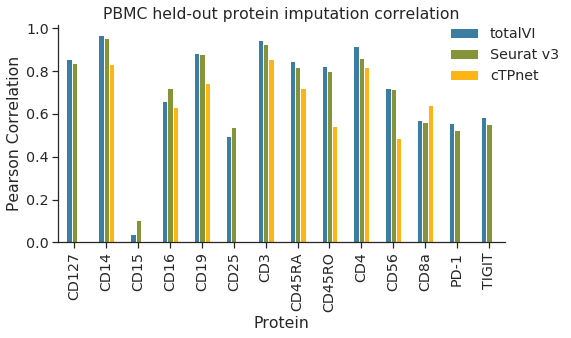

In [28]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(8, 4))
    pear_corrs.plot(kind="bar", ax=ax)
    ax.set_ylabel("Pearson Correlation")
    ax.set_xlabel("Protein")
    plt.legend(fancybox=True, bbox_to_anchor=(0.65, 0.55, 0.5, 0.5), frameon=False)
    ax.set_title("PBMC held-out protein imputation correlation")
    sns.despine()
    fig.savefig("figures/pbmc_imputation_correlation_pearson.pdf", bbox_inches="tight")

In [33]:
mask = pear_corrs["cTPnet"].isna().values
errors["cTPnet"].iloc[mask] = np.nan
errors

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/pandas-0.25.1-py3.7-linux-x86_64.egg/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,totalVI,Seurat v3,cTPnet
CD127,1.327,1.419,NaN
CD14,1.214,1.307,4.465
CD15,2.603,2.451,NaN
CD16,3.456,3.043,2.693
CD19,0.77,0.734,3.023
CD25,1.549,1.511,NaN
CD3,1.388,1.435,3.623
CD45RA,2.413,2.433,3.159
CD45RO,2.055,2.085,4.704
CD4,1.406,1.62,4.481


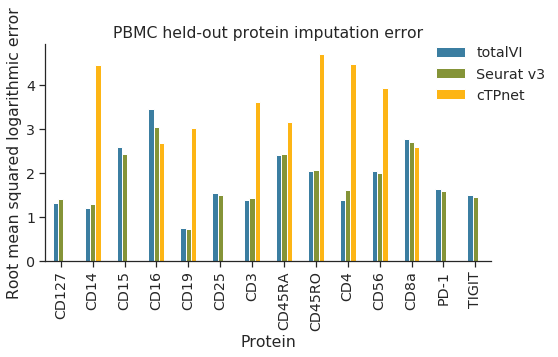

In [34]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(8, 4))
    errors.plot(kind="bar", ax=ax)
    ax.set_ylabel("Root mean squared logarithmic error")
    ax.set_xlabel("Protein")
    plt.legend(fancybox=True, bbox_to_anchor=(0.65, 0.55, 0.5, 0.5), frameon=False)
    ax.set_title("PBMC held-out protein imputation error")
    sns.despine()
    fig.savefig("figures/pbmc_imputation_msle.pdf", bbox_inches="tight")